# COVID diagnosis - book 2

## Summary

* Problem
    * Predict whether people have covid as accurately as possible - book 2
    * What symptoms/body conditions could be a sign for COVID - book 1
* Dataset - [Coronavirus Disease 2019 (COVID-19) Clinical Data Repository](https://covidclinicaldata.org/)
* EDA - Analyze association between posivity of covid test and symptoms that the patients have - book1
* Modeling - book2
    * Neural Network
    * `VotingClassifier` with `XGB`, `RandomForest`, `LogisticRegression`, `SVM`
* Conclusion
    * Below features are relatively big signs that infer you would have COVID more likely
        * Loss of smell
        * Loss of taste
        * Muscle sore
        * Body temperature
        * Heaedach
    * Neural Network with 77 % accuracy

## Problem

COVID made big impact on our world. It infects through countries rapidly and bring severe health problem all over the world.

I analyzed what kind of people should go diagnosis for covid. Idealy everyone should go but it is not very realistic and will be big loaden on hospitals so I would like to provide health workers insights that what kind of people is infected by COVID more likely so this analysis could help the health workers to pre-screen patients and would reduce infection on site.

I got dataset of COVID test results and the patients clinic information. I would like to find symptoms or clinic information which have relatively strong assciation with COVID positivity. Also I would like to create predictive model as accurately as possible.

This predictive model could help both of health workers and patients that they could know if the patients are positive by answering questions so this reduce their time and loaden a lot.

## Dataset

Obtained from [Coronavirus Disease 2019 (COVID-19) Clinical Data Repository](https://covidclinicaldata.org/)

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)

In [2]:
# read each csv data and combine them into DataFrame
df = pd.concat([pd.read_csv('../data/'+csv) for csv in os.listdir('../data/')[1:]])
df.head()

,batch_date,test_name,swab_type,covid19_test_results,age,high_risk_exposure_occupation,high_risk_interactions,diabetes,chd,htn,...,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat,cxr_findings,cxr_impression,cxr_label,cxr_link,er_referral
0,2020-04-07,SARS COV 2 RNA RTPCR,Nasopharyngeal,Negative,58,True,NaN,False,False,False,...,False,False,False,False,False,NaN,NaN,NaN,NaN,False
1,2020-04-07,"SARS-CoV-2, NAA",Oropharyngeal,Negative,35,False,NaN,False,False,False,...,False,False,False,False,False,NaN,NaN,NaN,NaN,False
2,2020-04-07,SARS CoV w/CoV 2 RNA,Oropharyngeal,Negative,12,NaN,NaN,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,2020-04-07,SARS COV 2 RNA RTPCR,Nasopharyngeal,Negative,46,True,True,False,False,False,...,False,False,False,False,True,NaN,NaN,NaN,NaN,False
4,2020-04-07,SARS CoV w/CoV 2 RNA,Nasopharyngeal,Negative,-1,False,NaN,False,False,False,...,False,False,False,False,False,NaN,NaN,NaN,NaN,False


#### Check values under the label `covid19_test_results`

In [3]:
df['covid19_test_results'].value_counts()

Negative    92682
Positive     1313
Name: covid19_test_results, dtype: int64

### Note

This dataset is very unbalanced. 98% of the result was negative and only 2% was positive. If I create either of interpretable or prediciteve model, I need to resample for positive or reduce negative data and have those in same scale

I would like to keep as much `Positive` as possible so it would be good to separate the `DataFrame` into `positive` and `negative` which stores only one of the two result respectively for following process. Before that, I converted `cogid19_test_results` to numerical values.

In [4]:
df = df.replace('Positive', 1).replace('Negative', 0)


# DataFrames store each of Positive and Negative

negative = df[df['covid19_test_results']==0]
positive = df[df['covid19_test_results']==1]

#### Check `positive` information to clean itself

In [5]:
positive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1313 entries, 21 to 6773
Data columns (total 46 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   batch_date                     1313 non-null   object 
 1   test_name                      1313 non-null   object 
 2   swab_type                      1313 non-null   object 
 3   covid19_test_results           1313 non-null   int64  
 4   age                            1313 non-null   int64  
 5   high_risk_exposure_occupation  1308 non-null   object 
 6   high_risk_interactions         1078 non-null   object 
 7   diabetes                       1313 non-null   bool   
 8   chd                            1313 non-null   bool   
 9   htn                            1313 non-null   bool   
 10  cancer                         1313 non-null   bool   
 11  asthma                         1313 non-null   bool   
 12  copd                           1313 non-null   

#### Check `negative` information to clean itself. `positive` contains around 1300 rows so I will reduce `negative` to same scale as `positive`

In [6]:
negative.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92682 entries, 0 to 7293
Data columns (total 46 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   batch_date                     92682 non-null  object 
 1   test_name                      92682 non-null  object 
 2   swab_type                      92682 non-null  object 
 3   covid19_test_results           92682 non-null  int64  
 4   age                            92682 non-null  int64  
 5   high_risk_exposure_occupation  92518 non-null  object 
 6   high_risk_interactions         68090 non-null  object 
 7   diabetes                       92682 non-null  bool   
 8   chd                            92682 non-null  bool   
 9   htn                            92682 non-null  bool   
 10  cancer                         92682 non-null  bool   
 11  asthma                         92682 non-null  bool   
 12  copd                           92682 non-null  

---

I dropped columns which I believed would not have association with `covid19_test_results` and also columns which has so many missing values that I could not analyze.

---

In [7]:
features_to_drop = ['batch_date', 'test_name', 'swab_type', 'rapid_flu_results', 
'rapid_strep_results', 'days_since_symptom_onset', 'cxr_findings', 'cough_severity', 'sob_severity',
'cxr_impression', 'cxr_label', 'cxr_link', 'er_referral']

positive = positive.drop(features_to_drop, axis=1)
negative = negative.drop(features_to_drop, axis=1)

---

Now I found `copd` in `positive` has only 0. I dropped `copd` as I cannot find association

---

In [8]:
positive['copd'].value_counts()

False    1313
Name: copd, dtype: int64

In [9]:
positive.drop(columns={'copd'}, inplace=True)
negative.drop(columns={'copd'}, inplace=True)

`negative` has very much more rows than `positive`. I believed it would not be problem that I dropped all missing values from `negative`

In [10]:
negative = negative.dropna()
negative.shape

(17044, 32)

In [11]:
# reset index

positive.reset_index(drop=True, inplace=True)
negative.reset_index(drop=True, inplace=True)

I would like to keep as many rows as possible in `positive` because the data size is small. I would like to fill missing values with random values, however there are many `object` columns so I converted these to numeric beforehand.

In [12]:
positive = positive.replace(True, 1).replace(False, 0)
positive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1313 entries, 0 to 1312
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   covid19_test_results           1313 non-null   int64  
 1   age                            1313 non-null   int64  
 2   high_risk_exposure_occupation  1308 non-null   float64
 3   high_risk_interactions         1078 non-null   float64
 4   diabetes                       1313 non-null   int64  
 5   chd                            1313 non-null   int64  
 6   htn                            1313 non-null   int64  
 7   cancer                         1313 non-null   int64  
 8   asthma                         1313 non-null   int64  
 9   autoimmune_dis                 1313 non-null   int64  
 10  smoker                         1313 non-null   int64  
 11  temperature                    1071 non-null   float64
 12  pulse                          1082 non-null   f

In [13]:
negative = negative.replace(True, 1).replace(False, 0)
negative.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17044 entries, 0 to 17043
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   covid19_test_results           17044 non-null  int64  
 1   age                            17044 non-null  int64  
 2   high_risk_exposure_occupation  17044 non-null  int64  
 3   high_risk_interactions         17044 non-null  int64  
 4   diabetes                       17044 non-null  int64  
 5   chd                            17044 non-null  int64  
 6   htn                            17044 non-null  int64  
 7   cancer                         17044 non-null  int64  
 8   asthma                         17044 non-null  int64  
 9   autoimmune_dis                 17044 non-null  int64  
 10  smoker                         17044 non-null  int64  
 11  temperature                    17044 non-null  float64
 12  pulse                          17044 non-null 

I confirmed `positive` and `negative` now have only numerical columns. Now I would like to assign random values. I believed it would bring better result that the random values follow distribution of the columns. There are 2 kinds of columns as below. I would like to look into respectively.

* Binomial
* Continuous

First, I checked which columns are binomial and versa vice

In [14]:
positive.describe().iloc[:, :10]

,covid19_test_results,age,high_risk_exposure_occupation,high_risk_interactions,diabetes,chd,htn,cancer,asthma,autoimmune_dis
count,1313.0,1313.000000,1308.000000,1078.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000
mean,1.0,35.577304,0.164373,0.195733,0.020564,0.007616,0.066260,0.003808,0.025895,0.001523
std,0.0,15.522810,0.370756,0.396948,0.141972,0.086971,0.248832,0.061615,0.158882,0.039014
min,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.0,33.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.0,46.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.0,83.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
positive.describe().iloc[:, 10:20]

,smoker,temperature,pulse,sys,dia,rr,sats,ctab,labored_respiration,rhonchi
count,1313.00000,1071.000000,1082.000000,1064.000000,1064.000000,968.000000,1076.000000,885.000000,1077.000000,591.000000
mean,0.04722,36.923576,81.547135,124.839286,79.663534,15.049587,98.151487,0.183051,0.012071,0.172589
std,0.21219,0.374418,13.625631,16.547304,9.646506,2.071529,1.450039,0.386927,0.109252,0.378212
min,0.00000,35.800000,49.000000,88.000000,41.000000,10.000000,87.000000,0.000000,0.000000,0.000000
25%,0.00000,36.700000,72.000000,114.000000,74.000000,14.000000,97.000000,0.000000,0.000000,0.000000
50%,0.00000,36.900000,80.000000,123.000000,79.000000,16.000000,98.000000,0.000000,0.000000,0.000000
75%,0.00000,37.100000,90.000000,134.000000,85.000000,16.000000,99.000000,0.000000,0.000000,0.000000
max,1.00000,39.200000,140.000000,210.000000,130.000000,26.000000,100.000000,1.000000,1.000000,1.000000


In [16]:
positive.describe().iloc[:, 20:]

,wheezes,cough,fever,sob,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat
count,690.000000,1313.000000,1106.000000,1308.000000,1308.000000,1308.000000,1308.000000,1308.000000,1308.000000,1308.000000,1308.000000,1308.000000
mean,0.213043,0.300838,0.199819,0.081040,0.061927,0.176606,0.224771,0.120795,0.107034,0.110856,0.178135,0.156728
std,0.409755,0.458797,0.400045,0.273001,0.241114,0.381480,0.417591,0.326014,0.309274,0.314074,0.382772,0.363683
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
# discreate stores binomial columns. continuous stores otherweise

discrete = ['high_risk_exposure_occupation', 'high_risk_interactions', 'diabetes', 'chd', 'htn', 'cancer', 'asthma', 'autoimmune_dis',
            'smoker', 'ctab', 'labored_respiration', 'rhonchi', 'wheezes', 'cough', 'fever', 'sob','diarrhea', 'fatigue', 
            'headache', 'loss_of_smell', 'loss_of_taste', 'runny_nose', 'muscle_sore', 'sore_throat']
continuous = ['age', 'temperature', 'pulse', 'sys', 'dia', 'rr', 'sats', ]

First, see distribution of `high_risk_exposure_occupation` and generate random values based on the distribution then assign those in the raws

In [18]:
# check distribution of high_risk_exposure_occupation

positive['high_risk_exposure_occupation'].value_counts(1)

0.0    0.835627
1.0    0.164373
Name: high_risk_exposure_occupation, dtype: float64

In [19]:
# index missing high_risk_exposure_occupation data

temp_missing_index = positive[positive['high_risk_exposure_occupation'].isnull()].index
temp_missing_index

Int64Index([26, 74, 82, 104, 264], dtype='int64')

In [20]:
# randomly generate 0 or 1 with probability made by the distribution

prob_zero = positive['high_risk_exposure_occupation'].value_counts(1)[0]
prob_one =positive['high_risk_exposure_occupation'].value_counts(1)[1]

temp_random = np.random.choice([0, 1], p=[prob_zero, prob_one], size=len(temp_missing_index))
temp_random

array([0, 1, 0, 0, 0])

In [21]:
# check missing rows

positive.iloc[temp_missing_index]

,covid19_test_results,age,high_risk_exposure_occupation,high_risk_interactions,diabetes,chd,htn,cancer,asthma,autoimmune_dis,...,fever,sob,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat
26,1,32,NaN,NaN,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,1,67,NaN,NaN,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82,1,24,NaN,NaN,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,1,54,NaN,NaN,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
264,1,21,NaN,NaN,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


I see `high_risk_exposure_occupation` has missing values at 26, 74, 82, 104, 264.

I filled these index with `temp_random`

In [22]:
positive.loc[temp_missing_index, 'high_risk_exposure_occupation'] = temp_random
positive.iloc[temp_missing_index]

,covid19_test_results,age,high_risk_exposure_occupation,high_risk_interactions,diabetes,chd,htn,cancer,asthma,autoimmune_dis,...,fever,sob,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat
26,1,32,0.0,NaN,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,1,67,1.0,NaN,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82,1,24,0.0,NaN,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,1,54,0.0,NaN,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
264,1,21,0.0,NaN,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now I would like to fill other columns so I created a function to apply same method as `high_risk_exposure_occupation` on all other columns

In [23]:
def assign_binomial_values(column):
    
    temp_missing_index = positive[positive[column].isnull()].index
    prob_zero = positive[column].value_counts(1)[0]
    prob_one =positive[column].value_counts(1)[1]

    temp_random = np.random.choice([0, 1], p=[prob_zero, prob_one], size=len(temp_missing_index))
    positive.loc[temp_missing_index, column] = temp_random

In [24]:
# assign random values for binomial columns

for column in discrete:
    assign_binomial_values(column)

In [25]:
# check missing values

positive.isnull().sum()[discrete]

high_risk_exposure_occupation    0
high_risk_interactions           0
diabetes                         0
chd                              0
htn                              0
cancer                           0
asthma                           0
autoimmune_dis                   0
smoker                           0
ctab                             0
labored_respiration              0
rhonchi                          0
wheezes                          0
cough                            0
fever                            0
sob                              0
diarrhea                         0
fatigue                          0
headache                         0
loss_of_smell                    0
loss_of_taste                    0
runny_nose                       0
muscle_sore                      0
sore_throat                      0
dtype: int64

I successfully filled all columns of `discrete` with random values which follow its column's distribution

Now I would like to assign values to continuos columns. First let's check distribution of the columns

In [26]:
# check missing values for continuous columns

positive[continuous].isnull().sum()

age              0
temperature    242
pulse          231
sys            249
dia            249
rr             345
sats           237
dtype: int64

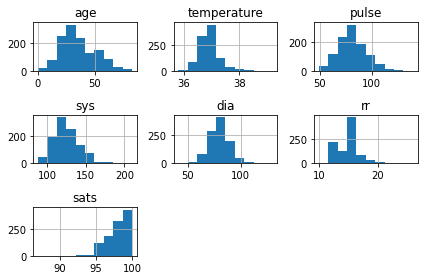

In [27]:
# histgram of continuous columns

positive[continuous].hist()
plt.tight_layout()

I would like to generate random values for `temperature` and I would like to have these values follow its column's distribution as well

I filled missing index of `temperature` first.
I used `stats.beta` to generate similar distribution to `temperature` then used this values as probability when I assigned random values.

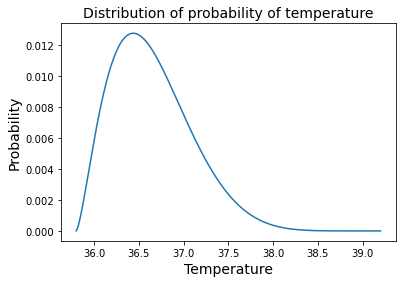

In [28]:
import scipy.stats as stats

# instanciate beta diustribution
temp_beta = stats.beta(2.5, 7.5)

# temperature range
temperature_max = positive['temperature'].max()
temperature_min = positive['temperature'].min()
temp_length = positive['temperature'].isnull().sum()
temp_range = np.linspace(temperature_min, temperature_max, temp_length)

# generate beta distribution
temp_distribution = temp_beta.pdf(np.linspace(0, 1, temp_length))

# normalized beta distirbution to get the values which range 0 to 1 which is going to be used as the possibility
beta_max = max(temp_distribution)
beta_min = min(temp_distribution)
beta_norm = (temp_distribution - beta_min) / (beta_max - beta_min)
temp_prob = beta_norm/sum(beta_norm)

plt.plot(temp_range, temp_prob)
plt.xlabel('Temperature', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.title('Distribution of probability of temperature', fontsize=14);

I generated beta distriution which is similar to `temperature` distribution. I used this beta for possibility of random values of `temperature`

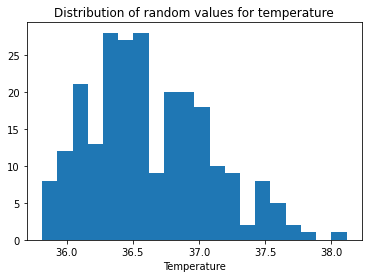

In [29]:
# generate random values for temperature with possibility of the beta distribution


temp_random = np.random.choice(temp_range, size=temp_length, p=temp_prob)
plt.hist(temp_random, bins=20)
plt.xlabel('Temperature')
plt.title('Distribution of random values for temperature');

In [30]:
# check missing rows of temperature

positive[positive['temperature'].isnull()].head()[continuous]

,age,temperature,pulse,sys,dia,rr,sats
12,31,NaN,69.0,132.0,82.0,NaN,96.0
26,32,NaN,NaN,NaN,NaN,NaN,NaN
40,76,NaN,96.0,NaN,NaN,NaN,NaN
49,72,NaN,NaN,144.0,82.0,NaN,NaN
62,41,NaN,89.0,134.0,84.0,NaN,98.0


In [31]:
temp_missing_index = positive[positive['temperature'].isnull()].index
positive.loc[temp_missing_index, 'temperature'] = temp_random

In [32]:
# successfully filled missing values with the random values for temperature

positive.iloc[temp_missing_index, :][continuous].head()

,age,temperature,pulse,sys,dia,rr,sats
12,31,36.956846,69.0,132.0,82.0,NaN,96.0
26,32,36.674689,NaN,NaN,NaN,NaN,NaN
40,76,37.507054,96.0,NaN,NaN,NaN,NaN
49,72,36.251452,NaN,144.0,82.0,NaN,NaN
62,41,36.124481,89.0,134.0,84.0,NaN,98.0


I successfully assigned random values for `temperature`. Now I would liketo to take care of other columns. I made a function to apply same method as `temperature` on all other continuous colomuns. However, distribution of `temperature` is right-skewed but some of other columns are not. I would like to change parameters for `stats.beta` based on distributiohn of the column.

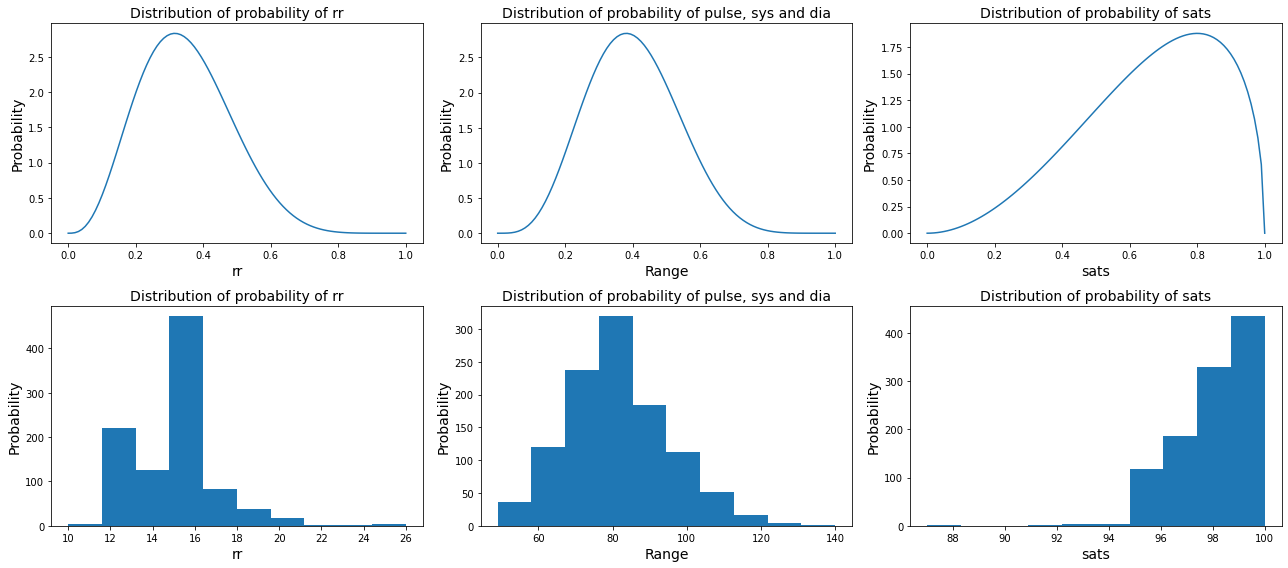

In [33]:
plt.figure(figsize=(18, 8))

plt.subplot(2,3,1)
temp_beta = stats.beta(4, 7.5)
temp_x = np.linspace(0, 1, 100)
plt.plot(temp_x, temp_beta.pdf(temp_x))
plt.xlabel('rr', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.title('Distribution of probability of rr', fontsize=14)

plt.subplot(2,3,2)
temp_beta = stats.beta(5, 7.5)
temp_x = np.linspace(0, 1, 100)
plt.plot(temp_x, temp_beta.pdf(temp_x))
plt.xlabel('Range', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.title('Distribution of probability of pulse, sys and dia', fontsize=14)

plt.subplot(2,3,3)
temp_beta = stats.beta(3, 1.5)
temp_x = np.linspace(0, 1, 100)
plt.plot(temp_x, temp_beta.pdf(temp_x))
plt.xlabel('sats', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.title('Distribution of probability of sats', fontsize=14)

plt.subplot(2,3,4)
plt.hist(positive['rr'])
plt.xlabel('rr', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.title('Distribution of probability of rr', fontsize=14)

plt.subplot(2,3,5)
plt.hist(positive['pulse'])
plt.xlabel('Range', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.title('Distribution of probability of pulse, sys and dia', fontsize=14)

plt.subplot(2,3,6)
plt.hist(positive['sats'])
plt.xlabel('sats', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.title('Distribution of probability of sats', fontsize=14)

plt.tight_layout()

---

I generated `beta` plot for each column and believed these `beta` distribution with below parameters are close to distribiton of each column respectively.

|Column|alpha|beta|
|-|-|-|
|rr|4|7.5|
|pulse|5|7.5|
|sys|5|7.5|
|dia|5|7.5|
|sats|3|1.5|

I used these beta distribution to generate random values as I did with `temperature`.

---

In [34]:
# function to assign random values

def assign_random_values(column):
    
    if column == 'rr':
        alpha, beta = 4, 7.5
    elif column == 'sats':
        alpha, beta = 3, 1.5
    else:
        alpha, beta = 5, 7.5
    
    temp_beta = stats.beta(alpha, beta)
    temp_max = positive[column].max()
    temp_min = positive[column].min()
    temp_length = positive[column].isnull().sum()
    temp_range = np.linspace(temperature_min, temperature_max, temp_length)

    temp_distribution = temp_beta.pdf(np.linspace(0, 1, temp_length))

    beta_max = max(temp_distribution)
    beta_min = min(temp_distribution)

    beta_norm = (temp_distribution - beta_min) / (beta_max - beta_min)
    temp_prob = beta_norm/sum(beta_norm)
    
    temp_random = np.random.choice(temp_range, size=temp_length, p=temp_prob)
    temp_missing_index = positive[positive[column].isnull()].index
    positive.loc[temp_missing_index, column] = temp_random

In [35]:
for column in ['pulse', 'sys', 'dia', 'rr', 'sats']:
    assign_random_values(column)

In [36]:
positive.isnull().sum()

covid19_test_results             0
age                              0
high_risk_exposure_occupation    0
high_risk_interactions           0
diabetes                         0
chd                              0
htn                              0
cancer                           0
asthma                           0
autoimmune_dis                   0
smoker                           0
temperature                      0
pulse                            0
sys                              0
dia                              0
rr                               0
sats                             0
ctab                             0
labored_respiration              0
rhonchi                          0
wheezes                          0
cough                            0
fever                            0
sob                              0
diarrhea                         0
fatigue                          0
headache                         0
loss_of_smell                    0
loss_of_taste       

I successfully filled out all missing values for `continuous` as well

## Modeling

Now I would like to train below models.

* GridSearch
    * RandomForest
    * LogisticRegression
    * XGBoost
    * SVM
* Neural Network

### Neural Network

I would like to assemble Neural Network first. Before that, I checked data size of `positive` and `negative` because if this was unbalanced `DataFrame`, the models would predict always same result.

In [37]:
print('positive size: ', len(positive))
print('negative size: ', len(negative))

positive size:  1313
negative size:  17044


`negative` size is much bigger than `positive`. If I used these entire data, the models would always predict `negative` more likely so I sampled `negative` in same scale as `positive`.

In [38]:
negative_sampled = negative.sample(n=positive.shape[0], replace=True)

---

Set features and lables. Also Scale and split to train and test data.



In [39]:
from sklearn.model_selection import train_test_split

# set features and label
X = pd.concat([positive, negative_sampled]).drop(columns={'covid19_test_results'})
y = pd.concat([positive, negative_sampled])['covid19_test_results']

# split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

from sklearn.preprocessing import StandardScaler

# scaling
ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

print('features shape: ', X.shape)
print('label shape: ', y.shape)

features shape:  (2626, 31)
label shape:  (2626,)


In [44]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

nn = Sequential()
nn.add(Dense(32, input_shape=(Z_train.shape[1],),activation='relu'))
nn.add(Dense(16, activation='relu'))
nn.add(Dense(1, activation='sigmoid'))

nn.compile(loss='bce', optimizer='adam', metrics=['acc'])


early_stop = EarlyStopping(patience=5)
results = nn.fit(Z_train, y_train, validation_data=(Z_test, y_test), epochs=100, batch_size=256, verbose=0, callbacks=[early_stop])

In [50]:
print('Train score: ', results.history['acc'][-1])
print('Test score: ', results.history['val_acc'][-1])

Train score:  0.8136109709739685
Test score:  0.7777777910232544


### GridSearch

* LogisticRegression
* SVM
* RandomForest
* XGBClassifier

In [52]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

I used `VotingClassifier` to get result of each of the estimater at once.

In [66]:
vote = VotingClassifier([
    ('svm', SVC()),
    ('lr', LogisticRegression()),
    ('rf', RandomForestClassifier()),
    ('xgb', XGBClassifier())
])

params = {
    'lr__C': [.5, 1],
    'lr__max_iter': [100, 200],
    'rf__max_depth': [5, 10]
}

gs = GridSearchCV(vote, param_grid=params, cv=5, n_jobs=6, verbose=1)
gs.fit(Z_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    5.3s finished


GridSearchCV(cv=5,
             estimator=VotingClassifier(estimators=[('svm', SVC()),
                                                    ('lr',
                                                     LogisticRegression()),
                                                    ('rf',
                                                     RandomForestClassifier()),
                                                    ('xgb',
                                                     XGBClassifier(base_score=None,
                                                                   booster=None,
                                                                   colsample_bylevel=None,
                                                                   colsample_bynode=None,
                                                                   colsample_bytree=None,
                                                                   gamma=None,
                                                                



I succesfully fitted `VotingClassifier`. Now I would like to check accuracy of each estimators respectively. I created `DataFrame` to refer the each score easily.



In [68]:
best_estimator = gs.best_estimator_

# Make DataFrame to store scores of each estimator
scores = {}
for name, estimator in best_estimator.named_estimators_.items():
    scores[name+'_train'] = estimator.score(Z_train, y_train)
    scores[name+'_test'] = estimator.score(Z_test, y_test)

In [69]:
# add VotingClassifier result in the DataFrame
scores['voting_train'] = best_estimator.score(Z_train, y_train)
scores['voting_test'] = best_estimator.score(Z_test, y_test)
models = {}

models['1'] = scores
pd.DataFrame.from_dict(models, orient='index')

,svm_train,svm_test,lr_train,lr_test,rf_train,rf_test,xgb_train,xgb_test,voting_train,voting_test
1,0.820721,0.762557,0.754698,0.724505,0.854241,0.756469,0.987303,0.754947,0.848654,0.744292


## Conclusion

Best model is `nn` with accuracy of `77%` with unseen data

### Recommendation and Note

This model would be used to pre-screen potential patients of COVID and reduce infections on site. In terms of use in medical site, the model is expected to be able to predict at over 99% accracy so there is a lot of space to improve. One way is get more data of `positive`, and `XGBoost` is especially high bias so I would get better result by reducing columns.